# GPT: Improving Language Understanding by Generative Pre-Training

## Part I: The Genesis of Modern Language Models

---

**Paper:** [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)

**Authors:** Alec Radford, Karthik Narasimhan, Tim Salimans, Ilya Sutskever (OpenAI)

**Published:** June 2018

---

This paper introduced the architecture and training paradigm that would eventually become GPT-2, GPT-3, GPT-4, and ChatGPT. While BERT often gets more attention in academic circles, GPT-1 was published four months earlier and established the decoder-only, autoregressive paradigm that dominates today's largest language models.

In this series, we will dissect every component of the original GPT, understand the design decisions, and implement it from scratch.

---

## Historical Context: June 2018

To appreciate GPT's contribution, we need to understand the state of NLP in mid-2018.

### The Landscape Before GPT

| Approach | Method | Limitation |
|----------|--------|------------|
| **Word2Vec/GloVe** | Static word embeddings | No context sensitivity |
| **ELMo** (Feb 2018) | Contextualized embeddings via BiLSTM | Feature-based, not fine-tuned end-to-end |
| **ULMFiT** (Jan 2018) | LM pre-training + fine-tuning | LSTM-based, limited to classification |

The critical insight that was missing: **Could we use the Transformer architecture (published just one year earlier) for transfer learning?**

### The Timeline

```
June 2017:  "Attention Is All You Need" (Transformer)
Jan 2018:   ULMFiT (Howard & Ruder)
Feb 2018:   ELMo (Peters et al.)
June 2018:  GPT-1 (Radford et al.)  <-- This paper
Oct 2018:   BERT (Devlin et al.)
Feb 2019:   GPT-2
```

GPT-1 was the first to combine:
1. Transformer architecture
2. Generative pre-training on large unlabeled corpus
3. Discriminative fine-tuning on downstream tasks

---

## The Core Problem

The paper opens with a fundamental challenge in NLP:

> *"Although large unlabeled text corpora are abundant, labeled data for learning these specific tasks is scarce, making it challenging for discriminatively trained models to perform adequately."*

### The Data Asymmetry

Consider the scale difference:

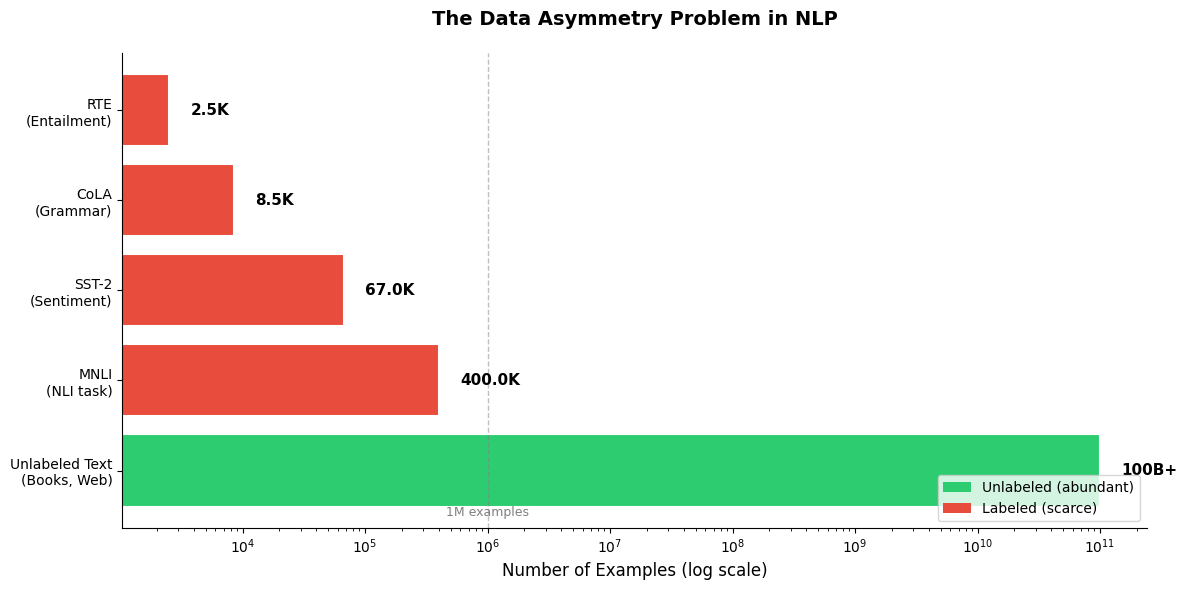

The gap is 5-6 orders of magnitude.
GPT's insight: Use the abundant unlabeled data to learn representations,
then fine-tune on the scarce labeled data.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data scale comparison (approximate, log scale)
datasets = {
    'Unlabeled Text\n(Books, Web)': 1e11,      # ~100B+ words available
    'MNLI\n(NLI task)': 4e5,                   # 433K examples
    'SST-2\n(Sentiment)': 6.7e4,              # 67K examples  
    'CoLA\n(Grammar)': 8.5e3,                 # 8.5K examples
    'RTE\n(Entailment)': 2.5e3,               # 2.5K examples
}

fig, ax = plt.subplots(figsize=(12, 6))

names = list(datasets.keys())
values = list(datasets.values())
colors = ['#2ecc71'] + ['#e74c3c'] * 4

bars = ax.barh(names, values, color=colors, edgecolor='white', linewidth=1.5)
ax.set_xscale('log')
ax.set_xlabel('Number of Examples (log scale)', fontsize=12)
ax.set_title('The Data Asymmetry Problem in NLP', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for bar, val in zip(bars, values):
    if val >= 1e9:
        label = f'{val/1e9:.0f}B+'
    elif val >= 1e6:
        label = f'{val/1e6:.0f}M'
    elif val >= 1e3:
        label = f'{val/1e3:.1f}K'
    else:
        label = f'{val:.0f}'
    ax.text(val * 1.5, bar.get_y() + bar.get_height()/2, label,
            va='center', fontsize=11, fontweight='bold')

ax.axvline(x=1e6, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(1e6, -0.5, '1M examples', ha='center', fontsize=9, color='gray')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Unlabeled (abundant)'),
    Patch(facecolor='#e74c3c', label='Labeled (scarce)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

print("The gap is 5-6 orders of magnitude.")
print("GPT's insight: Use the abundant unlabeled data to learn representations,")
print("then fine-tune on the scarce labeled data.")

### Two Fundamental Challenges

The paper identifies two key uncertainties that had prevented effective transfer learning in NLP:

**Challenge 1: What objective to optimize during pre-training?**

Different objectives capture different aspects of language:
- Language modeling (predict next word)
- Machine translation
- Discourse coherence

Which one produces representations that transfer best?

**Challenge 2: How to transfer learned representations?**

Previous approaches used:
- Task-specific architectures on top of pre-trained features (complex)
- Auxiliary objectives during fine-tuning (intricate)
- Custom learning schemes (hard to reproduce)

GPT's answer to both: **Keep it simple.**

---

## The GPT Solution: Two-Stage Training

GPT proposes a remarkably elegant approach:

### Stage 1: Unsupervised Pre-training

Train a language model on a large corpus of unlabeled text.

**Objective:** Given a sequence of tokens, predict the next token.

$$L_1(\mathcal{U}) = \sum_i \log P(u_i | u_{i-k}, ..., u_{i-1}; \Theta)$$

Where:
- $\mathcal{U} = \{u_1, ..., u_n\}$ is the corpus of tokens
- $k$ is the context window size
- $\Theta$ are the model parameters

### Stage 2: Supervised Fine-tuning

Adapt the pre-trained model to specific downstream tasks.

$$L_2(\mathcal{C}) = \sum_{(x,y)} \log P(y | x^1, ..., x^m)$$

Where:
- $\mathcal{C}$ is the labeled dataset
- $x^1, ..., x^m$ is the input sequence
- $y$ is the label

**Key insight:** Also include the language modeling objective during fine-tuning as an auxiliary loss:

$$L_3(\mathcal{C}) = L_2(\mathcal{C}) + \lambda \cdot L_1(\mathcal{C})$$

This helps:
1. Improve generalization
2. Accelerate convergence

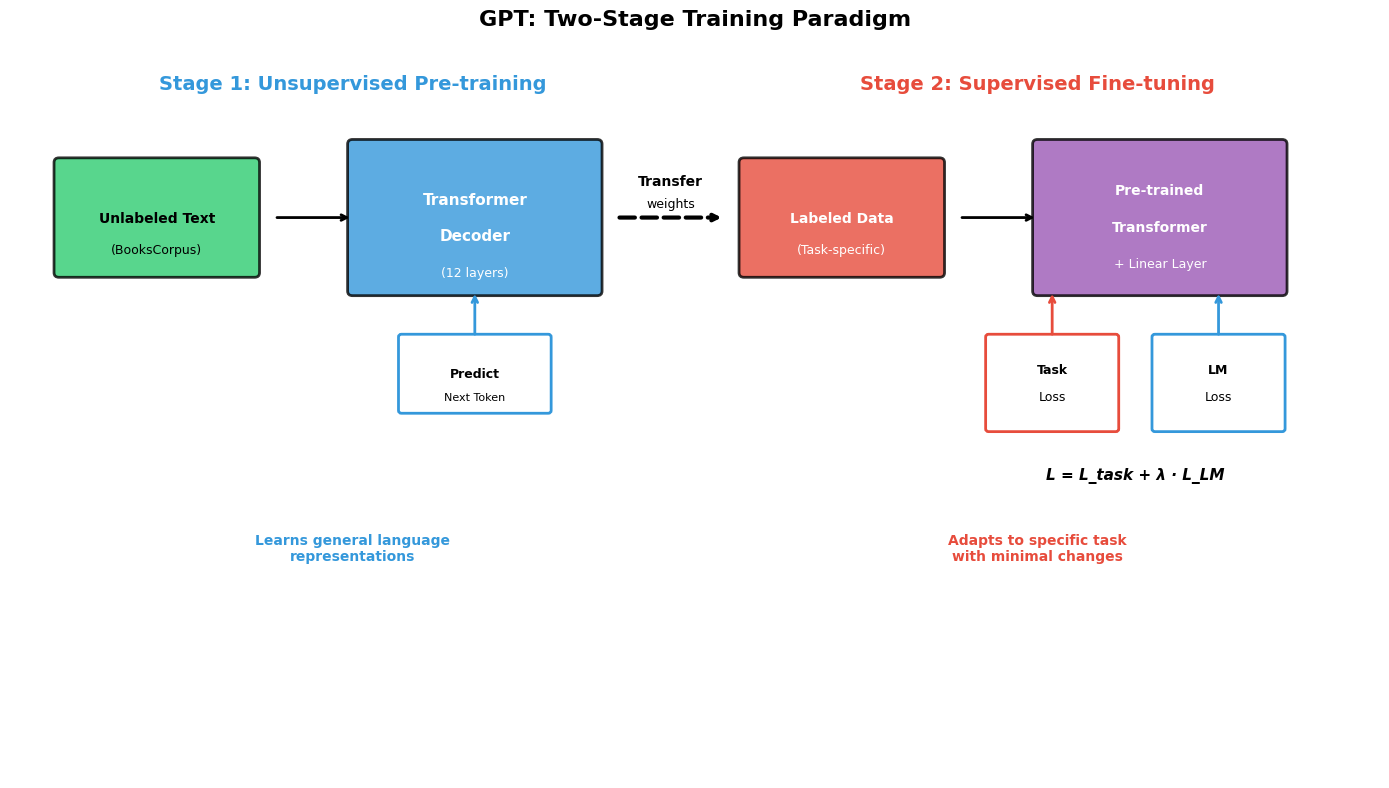

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Colors
pretrain_color = '#3498db'
finetune_color = '#e74c3c'
data_color = '#2ecc71'
model_color = '#9b59b6'

# Stage 1: Pre-training
ax.text(3.5, 7.5, 'Stage 1: Unsupervised Pre-training', fontsize=14, fontweight='bold',
        ha='center', color=pretrain_color)

# Unlabeled data
rect1 = FancyBboxPatch((0.5, 5.5), 2, 1.2, boxstyle="round,pad=0.05",
                        facecolor=data_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(rect1)
ax.text(1.5, 6.1, 'Unlabeled Text', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(1.5, 5.75, '(BooksCorpus)', ha='center', va='center', fontsize=9)

# Arrow
ax.annotate('', xy=(3.5, 6.1), xytext=(2.7, 6.1),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Transformer
rect2 = FancyBboxPatch((3.5, 5.3), 2.5, 1.6, boxstyle="round,pad=0.05",
                        facecolor=pretrain_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(rect2)
ax.text(4.75, 6.3, 'Transformer', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax.text(4.75, 5.9, 'Decoder', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax.text(4.75, 5.5, '(12 layers)', ha='center', va='center', fontsize=9, color='white')

# Objective
rect3 = FancyBboxPatch((4, 4), 1.5, 0.8, boxstyle="round,pad=0.03",
                        facecolor='white', edgecolor=pretrain_color, linewidth=2)
ax.add_patch(rect3)
ax.text(4.75, 4.4, 'Predict', ha='center', va='center', fontsize=9, fontweight='bold')
ax.text(4.75, 4.15, 'Next Token', ha='center', va='center', fontsize=8)

ax.annotate('', xy=(4.75, 5.3), xytext=(4.75, 4.8),
            arrowprops=dict(arrowstyle='->', color=pretrain_color, lw=2))

# Stage 2: Fine-tuning
ax.text(10.5, 7.5, 'Stage 2: Supervised Fine-tuning', fontsize=14, fontweight='bold',
        ha='center', color=finetune_color)

# Labeled data
rect4 = FancyBboxPatch((7.5, 5.5), 2, 1.2, boxstyle="round,pad=0.05",
                        facecolor=finetune_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(rect4)
ax.text(8.5, 6.1, 'Labeled Data', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(8.5, 5.75, '(Task-specific)', ha='center', va='center', fontsize=9, color='white')

# Arrow
ax.annotate('', xy=(10.5, 6.1), xytext=(9.7, 6.1),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Pre-trained + Linear
rect5 = FancyBboxPatch((10.5, 5.3), 2.5, 1.6, boxstyle="round,pad=0.05",
                        facecolor=model_color, edgecolor='black', linewidth=2, alpha=0.8)
ax.add_patch(rect5)
ax.text(11.75, 6.4, 'Pre-trained', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(11.75, 6.0, 'Transformer', ha='center', va='center', fontsize=10, fontweight='bold', color='white')
ax.text(11.75, 5.6, '+ Linear Layer', ha='center', va='center', fontsize=9, color='white')

# Two objectives
rect6 = FancyBboxPatch((10, 3.8), 1.3, 1, boxstyle="round,pad=0.03",
                        facecolor='white', edgecolor=finetune_color, linewidth=2)
ax.add_patch(rect6)
ax.text(10.65, 4.45, 'Task', ha='center', va='center', fontsize=9, fontweight='bold')
ax.text(10.65, 4.15, 'Loss', ha='center', va='center', fontsize=9)

rect7 = FancyBboxPatch((11.7, 3.8), 1.3, 1, boxstyle="round,pad=0.03",
                        facecolor='white', edgecolor=pretrain_color, linewidth=2)
ax.add_patch(rect7)
ax.text(12.35, 4.45, 'LM', ha='center', va='center', fontsize=9, fontweight='bold')
ax.text(12.35, 4.15, 'Loss', ha='center', va='center', fontsize=9)

ax.annotate('', xy=(10.65, 5.3), xytext=(10.65, 4.8),
            arrowprops=dict(arrowstyle='->', color=finetune_color, lw=2))
ax.annotate('', xy=(12.35, 5.3), xytext=(12.35, 4.8),
            arrowprops=dict(arrowstyle='->', color=pretrain_color, lw=2))

# Combined loss
ax.text(11.5, 3.3, 'L = L_task + λ · L_LM', ha='center', va='center', fontsize=11,
        fontweight='bold', style='italic')

# Transfer arrow
ax.annotate('', xy=(7.3, 6.1), xytext=(6.2, 6.1),
            arrowprops=dict(arrowstyle='->', color='black', lw=3, ls='--'))
ax.text(6.75, 6.5, 'Transfer', ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(6.75, 6.25, 'weights', ha='center', va='center', fontsize=9)

# Bottom annotations
ax.text(3.5, 2.5, 'Learns general language\nrepresentations', ha='center', va='center',
        fontsize=10, color=pretrain_color, fontweight='bold')
ax.text(10.5, 2.5, 'Adapts to specific task\nwith minimal changes', ha='center', va='center',
        fontsize=10, color=finetune_color, fontweight='bold')

plt.suptitle('GPT: Two-Stage Training Paradigm', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

---

## Why Decoder-Only? The Architectural Choice

This is perhaps the most consequential decision in the paper. GPT uses only the **decoder** part of the Transformer, while BERT (published 4 months later) uses only the **encoder**.

### The Transformer Encoder vs Decoder

| Component | Attention Type | Can See | Use Case |
|-----------|---------------|---------|----------|
| **Encoder** | Bidirectional | All tokens | Understanding |
| **Decoder** | Causal (masked) | Only past tokens | Generation |

### Why Causal (Left-to-Right) Attention?

Language modeling requires predicting the next token. If the model could see future tokens, the task becomes trivial (just copy the answer).

The causal mask ensures:
- Token at position $i$ can only attend to positions $\{1, 2, ..., i\}$
- This enables autoregressive generation at inference time

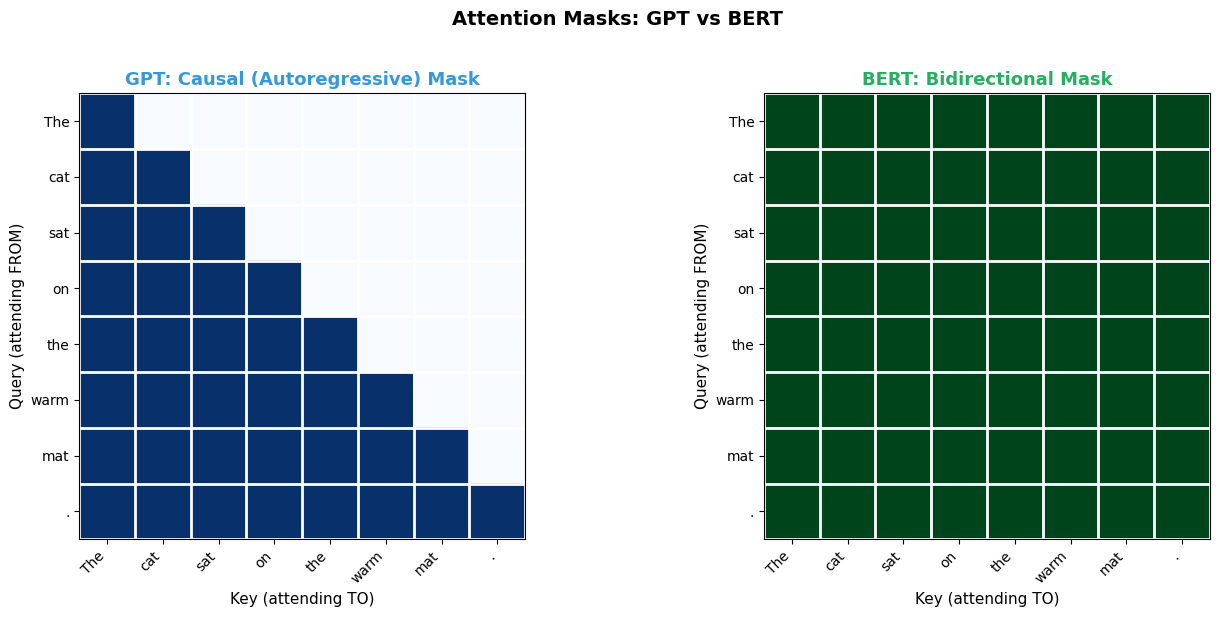

GPT (Causal):
  - 'sat' can see: 'The', 'cat', 'sat'
  - 'sat' cannot see: 'on', 'the', 'warm', 'mat', '.'
  - Enables next-token prediction during training
  - Enables autoregressive generation at inference

BERT (Bidirectional):
  - 'sat' can see: ALL tokens
  - Better for understanding tasks
  - Cannot do autoregressive generation


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def create_causal_mask(seq_len: int) -> torch.Tensor:
    """
    Create a causal (autoregressive) attention mask.
    
    The mask ensures that position i can only attend to positions <= i.
    This is the defining characteristic of decoder-only transformers.
    
    Args:
        seq_len: Length of the sequence
    
    Returns:
        Mask tensor of shape (seq_len, seq_len)
        1 = can attend, 0 = cannot attend
    """
    # torch.tril creates a lower triangular matrix
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask


def create_bidirectional_mask(seq_len: int) -> torch.Tensor:
    """
    Create a bidirectional attention mask (for comparison with BERT-style).
    All positions can attend to all positions.
    """
    return torch.ones(seq_len, seq_len)


# Visualize both mask types
seq_len = 8
tokens = ['The', 'cat', 'sat', 'on', 'the', 'warm', 'mat', '.']

causal_mask = create_causal_mask(seq_len)
bidirectional_mask = create_bidirectional_mask(seq_len)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GPT-style causal mask
ax1 = axes[0]
im1 = ax1.imshow(causal_mask.numpy(), cmap='Blues', vmin=0, vmax=1)
ax1.set_xticks(range(seq_len))
ax1.set_yticks(range(seq_len))
ax1.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(tokens, fontsize=10)
ax1.set_xlabel('Key (attending TO)', fontsize=11)
ax1.set_ylabel('Query (attending FROM)', fontsize=11)
ax1.set_title('GPT: Causal (Autoregressive) Mask', fontsize=13, fontweight='bold', color='#3498db')

# Add grid
for i in range(seq_len + 1):
    ax1.axhline(i - 0.5, color='white', linewidth=2)
    ax1.axvline(i - 0.5, color='white', linewidth=2)

# BERT-style bidirectional mask
ax2 = axes[1]
im2 = ax2.imshow(bidirectional_mask.numpy(), cmap='Greens', vmin=0, vmax=1)
ax2.set_xticks(range(seq_len))
ax2.set_yticks(range(seq_len))
ax2.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(tokens, fontsize=10)
ax2.set_xlabel('Key (attending TO)', fontsize=11)
ax2.set_ylabel('Query (attending FROM)', fontsize=11)
ax2.set_title('BERT: Bidirectional Mask', fontsize=13, fontweight='bold', color='#27ae60')

for i in range(seq_len + 1):
    ax2.axhline(i - 0.5, color='white', linewidth=2)
    ax2.axvline(i - 0.5, color='white', linewidth=2)

plt.suptitle('Attention Masks: GPT vs BERT', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("GPT (Causal):")
print("  - 'sat' can see: 'The', 'cat', 'sat'")
print("  - 'sat' cannot see: 'on', 'the', 'warm', 'mat', '.'")
print("  - Enables next-token prediction during training")
print("  - Enables autoregressive generation at inference")
print()
print("BERT (Bidirectional):")
print("  - 'sat' can see: ALL tokens")
print("  - Better for understanding tasks")
print("  - Cannot do autoregressive generation")

### The Trade-off

**GPT's approach (causal/unidirectional):**
- ✅ Can generate text autoregressively
- ✅ Simple, elegant training objective
- ✅ Same architecture for pre-training and generation
- ❌ Each token only sees left context

**BERT's approach (bidirectional):**
- ✅ Each token sees full context
- ✅ Often better for understanding tasks
- ❌ Cannot generate text naturally
- ❌ Requires special [MASK] token during pre-training

In hindsight, both approaches proved valuable. But for building large language models that can generate coherent text, GPT's decoder-only approach won.

---

## The Language Modeling Objective

GPT is trained to predict the next token given all previous tokens. This is the standard **autoregressive language modeling** objective.

### Mathematical Formulation

Given a sequence of tokens $\mathbf{u} = (u_1, u_2, ..., u_n)$, we model the joint probability as:

$$P(\mathbf{u}) = \prod_{i=1}^{n} P(u_i | u_1, u_2, ..., u_{i-1})$$

The training objective is to maximize the log-likelihood:

$$L(\mathbf{u}) = \sum_{i=1}^{n} \log P(u_i | u_1, ..., u_{i-1}; \Theta)$$

Or equivalently, minimize the negative log-likelihood (cross-entropy loss).

In [4]:
import torch
import torch.nn.functional as F

def autoregressive_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Compute the autoregressive language modeling loss.
    
    This is the core training objective of GPT: predict the next token
    at each position given all previous tokens.
    
    Args:
        logits: Model output, shape (batch, seq_len, vocab_size)
                logits[b, i, :] is the distribution over next token at position i
        targets: Ground truth tokens, shape (batch, seq_len)
                 targets[b, i] is the actual token at position i+1
    
    Returns:
        Scalar loss value (mean cross-entropy)
    """
    batch_size, seq_len, vocab_size = logits.shape
    
    # Flatten for cross-entropy
    # logits: (batch * seq_len, vocab_size)
    # targets: (batch * seq_len,)
    logits_flat = logits.view(-1, vocab_size)
    targets_flat = targets.view(-1)
    
    # Cross-entropy loss
    loss = F.cross_entropy(logits_flat, targets_flat)
    
    return loss


# Demonstrate the objective
print("Language Modeling Objective Demonstration")
print("=" * 50)
print()

# Example sequence
sentence = "The cat sat on the mat"
tokens = sentence.split()

print(f"Input sequence: {tokens}")
print()
print("Training pairs (input -> target):")
print("-" * 40)

for i in range(len(tokens)):
    context = tokens[:i+1] if i > 0 else ['<start>']
    if i < len(tokens) - 1:
        target = tokens[i+1]
        print(f"  {str(context):30s} -> '{target}'")
    else:
        print(f"  {str(context):30s} -> '<end>'")

print()
print("The model learns to predict each token given all previous tokens.")
print("This is done in parallel during training (teacher forcing).")

Language Modeling Objective Demonstration

Input sequence: ['The', 'cat', 'sat', 'on', 'the', 'mat']

Training pairs (input -> target):
----------------------------------------
  ['<start>']                    -> 'cat'
  ['The', 'cat']                 -> 'sat'
  ['The', 'cat', 'sat']          -> 'on'
  ['The', 'cat', 'sat', 'on']    -> 'the'
  ['The', 'cat', 'sat', 'on', 'the'] -> 'mat'
  ['The', 'cat', 'sat', 'on', 'the', 'mat'] -> '<end>'

The model learns to predict each token given all previous tokens.
This is done in parallel during training (teacher forcing).


### Why Language Modeling Works for Transfer Learning

This is a deep question that the paper addresses implicitly. Language modeling is effective because:

1. **It requires understanding.** To predict "mat" after "The cat sat on the", you need to understand:
   - Syntax (what words can follow)
   - Semantics (cats sit on things)
   - World knowledge (mats are common surfaces)

2. **It scales.** Unlimited training data is available (all text on the internet).

3. **It's self-supervised.** No human labeling required.

4. **The task is hard enough.** Next-token prediction captures rich linguistic structure.

---

## GPT Architecture Specifications

The paper uses a 12-layer Transformer decoder. Here are the exact specifications:

In [5]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    """
    Configuration for GPT-1 as specified in the paper.
    
    Reference: Section 4.1 of "Improving Language Understanding by Generative Pre-Training"
    
    "We trained a 12-layer decoder-only transformer with masked self-attention heads 
    (768 dimensional states and 12 attention heads). For the position-wise feed-forward 
    networks, we used 3072 dimensional inner states."
    """
    # Model architecture
    vocab_size: int = 40478          # BPE vocabulary size (40000 merges + special tokens)
    n_positions: int = 512           # Maximum sequence length
    n_embd: int = 768                # Embedding dimension (d_model)
    n_layer: int = 12                # Number of transformer layers
    n_head: int = 12                 # Number of attention heads
    n_inner: int = 3072              # Feed-forward inner dimension (4 * n_embd)
    
    # Regularization
    embd_pdrop: float = 0.1          # Embedding dropout
    attn_pdrop: float = 0.1          # Attention dropout
    resid_pdrop: float = 0.1         # Residual dropout
    
    # Training
    learning_rate: float = 2.5e-4    # Maximum learning rate
    warmup_tokens: int = 2000        # Linear warmup steps
    batch_size: int = 64             # Batch size
    n_epochs: int = 100              # Training epochs
    
    # Activation
    activation: str = 'gelu'         # GELU activation function
    
    def __post_init__(self):
        assert self.n_embd % self.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = self.n_embd // self.n_head


# Create config
config = GPTConfig()

# Display configuration
print("GPT-1 Architecture Configuration")
print("=" * 50)
print(f"\n{'Parameter':<25} {'Value':<15} {'Notes'}")
print("-" * 70)
print(f"{'Vocabulary size':<25} {config.vocab_size:<15} BPE with 40K merges")
print(f"{'Max sequence length':<25} {config.n_positions:<15} Context window")
print(f"{'Embedding dimension':<25} {config.n_embd:<15} d_model")
print(f"{'Number of layers':<25} {config.n_layer:<15} Transformer blocks")
print(f"{'Attention heads':<25} {config.n_head:<15} Per layer")
print(f"{'Head dimension':<25} {config.head_dim:<15} n_embd / n_head")
print(f"{'FFN inner dimension':<25} {config.n_inner:<15} 4 * n_embd")
print(f"{'Dropout':<25} {config.embd_pdrop:<15} All dropout rates")
print(f"{'Activation':<25} {config.activation:<15} Gaussian Error Linear Unit")

print("\n" + "=" * 50)
print("Training Configuration")
print("=" * 50)
print(f"{'Learning rate':<25} {config.learning_rate:<15} With cosine decay")
print(f"{'Warmup steps':<25} {config.warmup_tokens:<15} Linear warmup")
print(f"{'Batch size':<25} {config.batch_size:<15}")
print(f"{'Epochs':<25} {config.n_epochs:<15}")

GPT-1 Architecture Configuration

Parameter                 Value           Notes
----------------------------------------------------------------------
Vocabulary size           40478           BPE with 40K merges
Max sequence length       512             Context window
Embedding dimension       768             d_model
Number of layers          12              Transformer blocks
Attention heads           12              Per layer
Head dimension            64              n_embd / n_head
FFN inner dimension       3072            4 * n_embd
Dropout                   0.1             All dropout rates
Activation                gelu            Gaussian Error Linear Unit

Training Configuration
Learning rate             0.00025         With cosine decay
Warmup steps              2000            Linear warmup
Batch size                64             
Epochs                    100            


### Comparison with Original Transformer

| Parameter | Transformer (2017) | GPT-1 (2018) |
|-----------|-------------------|---------------|
| Layers | 6 (enc) + 6 (dec) | 12 (dec only) |
| d_model | 512 | 768 |
| Heads | 8 | 12 |
| d_ff | 2048 | 3072 |
| Max length | Not fixed | 512 |
| Positional | Sinusoidal | Learned |

GPT uses **learned positional embeddings** rather than sinusoidal encodings. This is another key difference from the original Transformer.

---

## Pre-training Data: BooksCorpus

GPT-1 was trained on the **BooksCorpus** dataset:

- ~7,000 unique unpublished books
- Diverse genres (adventure, fantasy, romance...)
- Long, contiguous text (unlike Wikipedia)

### Why Books?

The paper explains:

> *"It contains long stretches of contiguous text, which allows the generative model to learn to condition on long-range information."*

Compare this to alternatives:

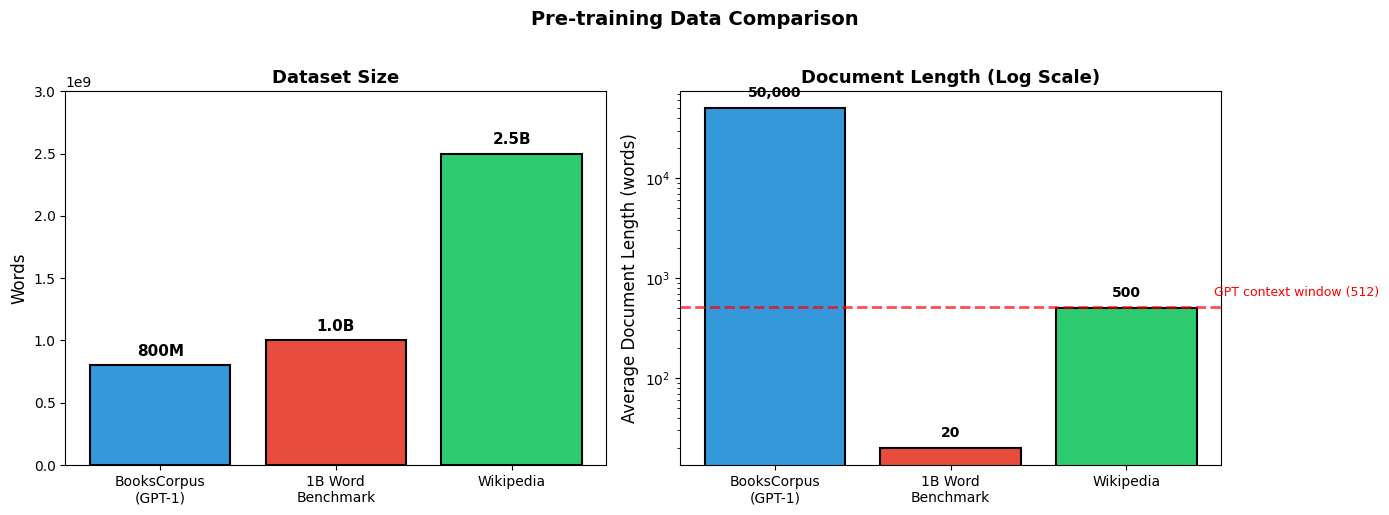

Key insight: BooksCorpus has LONG contiguous documents.
This allows learning long-range dependencies.

The 1B Word Benchmark, despite being larger, is shuffled at sentence level.
This destroys the long-range structure that GPT needs to learn.


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset comparison
datasets = {
    'BooksCorpus\n(GPT-1)': {
        'size_words': 800e6,
        'avg_doc_length': 50000,  # words per book (approximate)
        'contiguous': True,
        'color': '#3498db'
    },
    '1B Word\nBenchmark': {
        'size_words': 1e9,
        'avg_doc_length': 20,  # sentence-level shuffled
        'contiguous': False,
        'color': '#e74c3c'
    },
    'Wikipedia': {
        'size_words': 2.5e9,
        'avg_doc_length': 500,  # average article
        'contiguous': True,
        'color': '#2ecc71'
    }
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Dataset size
ax1 = axes[0]
names = list(datasets.keys())
sizes = [d['size_words'] for d in datasets.values()]
colors = [d['color'] for d in datasets.values()]

bars1 = ax1.bar(names, sizes, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Words', fontsize=12)
ax1.set_title('Dataset Size', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 3e9)

for bar, size in zip(bars1, sizes):
    label = f'{size/1e9:.1f}B' if size >= 1e9 else f'{size/1e6:.0f}M'
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05e9,
             label, ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: Document length (log scale)
ax2 = axes[1]
lengths = [d['avg_doc_length'] for d in datasets.values()]

bars2 = ax2.bar(names, lengths, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Document Length (words)', fontsize=12)
ax2.set_title('Document Length (Log Scale)', fontsize=13, fontweight='bold')
ax2.set_yscale('log')

for bar, length in zip(bars2, lengths):
    label = f'{length:,.0f}'
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2,
             label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add annotations
ax2.axhline(y=512, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.text(2.5, 512 * 1.3, 'GPT context window (512)', fontsize=9, color='red')

plt.suptitle('Pre-training Data Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Key insight: BooksCorpus has LONG contiguous documents.")
print("This allows learning long-range dependencies.")
print("\nThe 1B Word Benchmark, despite being larger, is shuffled at sentence level.")
print("This destroys the long-range structure that GPT needs to learn.")

---

## Tokenization: Byte Pair Encoding (BPE)

GPT uses **Byte Pair Encoding** with 40,000 merges. This is a subword tokenization method that:

1. Starts with individual characters
2. Iteratively merges the most frequent adjacent pairs
3. Builds a vocabulary of common subwords

### Why BPE?

- **Handles rare words:** "transformers" → ["transform", "ers"]
- **Efficient vocabulary:** ~40K tokens cover most text
- **No UNK tokens:** Any text can be tokenized

In [7]:
def demonstrate_bpe_concept():
    """
    Demonstrate the concept of Byte Pair Encoding.
    
    This is a simplified illustration - real BPE is more complex.
    """
    print("Byte Pair Encoding (BPE) - Conceptual Demonstration")
    print("=" * 55)
    print()
    
    # Example vocabulary building
    corpus = "low lower lowest newer newest"
    print(f"Corpus: '{corpus}'")
    print()
    
    # Initial: character level
    print("Step 0 (Initial - character level):")
    print("  Vocabulary: {l, o, w, e, r, s, t, n, ' '}")
    print("  'lower' -> ['l', 'o', 'w', 'e', 'r']")
    print()
    
    # After some merges
    print("After BPE merges:")
    print("  Most frequent pair 'e' + 'r' -> 'er'")
    print("  Most frequent pair 'e' + 'st' -> 'est'")
    print("  Most frequent pair 'l' + 'o' + 'w' -> 'low'")
    print()
    
    # Final tokenization
    print("Final tokenization examples:")
    examples = [
        ("lower", ["low", "er"]),
        ("lowest", ["low", "est"]),
        ("newest", ["new", "est"]),
        ("transformer", ["transform", "er"]),
        ("unhappiness", ["un", "happiness"]),
    ]
    
    for word, tokens in examples:
        print(f"  '{word}' -> {tokens}")
    
    print()
    print("GPT-1 uses 40,000 BPE merges.")
    print("This creates a vocabulary that balances:")
    print("  - Efficiency (common words are single tokens)")
    print("  - Coverage (rare words split into known subwords)")


demonstrate_bpe_concept()

Byte Pair Encoding (BPE) - Conceptual Demonstration

Corpus: 'low lower lowest newer newest'

Step 0 (Initial - character level):
  Vocabulary: {l, o, w, e, r, s, t, n, ' '}
  'lower' -> ['l', 'o', 'w', 'e', 'r']

After BPE merges:
  Most frequent pair 'e' + 'r' -> 'er'
  Most frequent pair 'e' + 'st' -> 'est'
  Most frequent pair 'l' + 'o' + 'w' -> 'low'

Final tokenization examples:
  'lower' -> ['low', 'er']
  'lowest' -> ['low', 'est']
  'newest' -> ['new', 'est']
  'transformer' -> ['transform', 'er']
  'unhappiness' -> ['un', 'happiness']

GPT-1 uses 40,000 BPE merges.
This creates a vocabulary that balances:
  - Efficiency (common words are single tokens)
  - Coverage (rare words split into known subwords)


---

## What Makes GPT Different from Previous Work?

Let's summarize the key innovations:

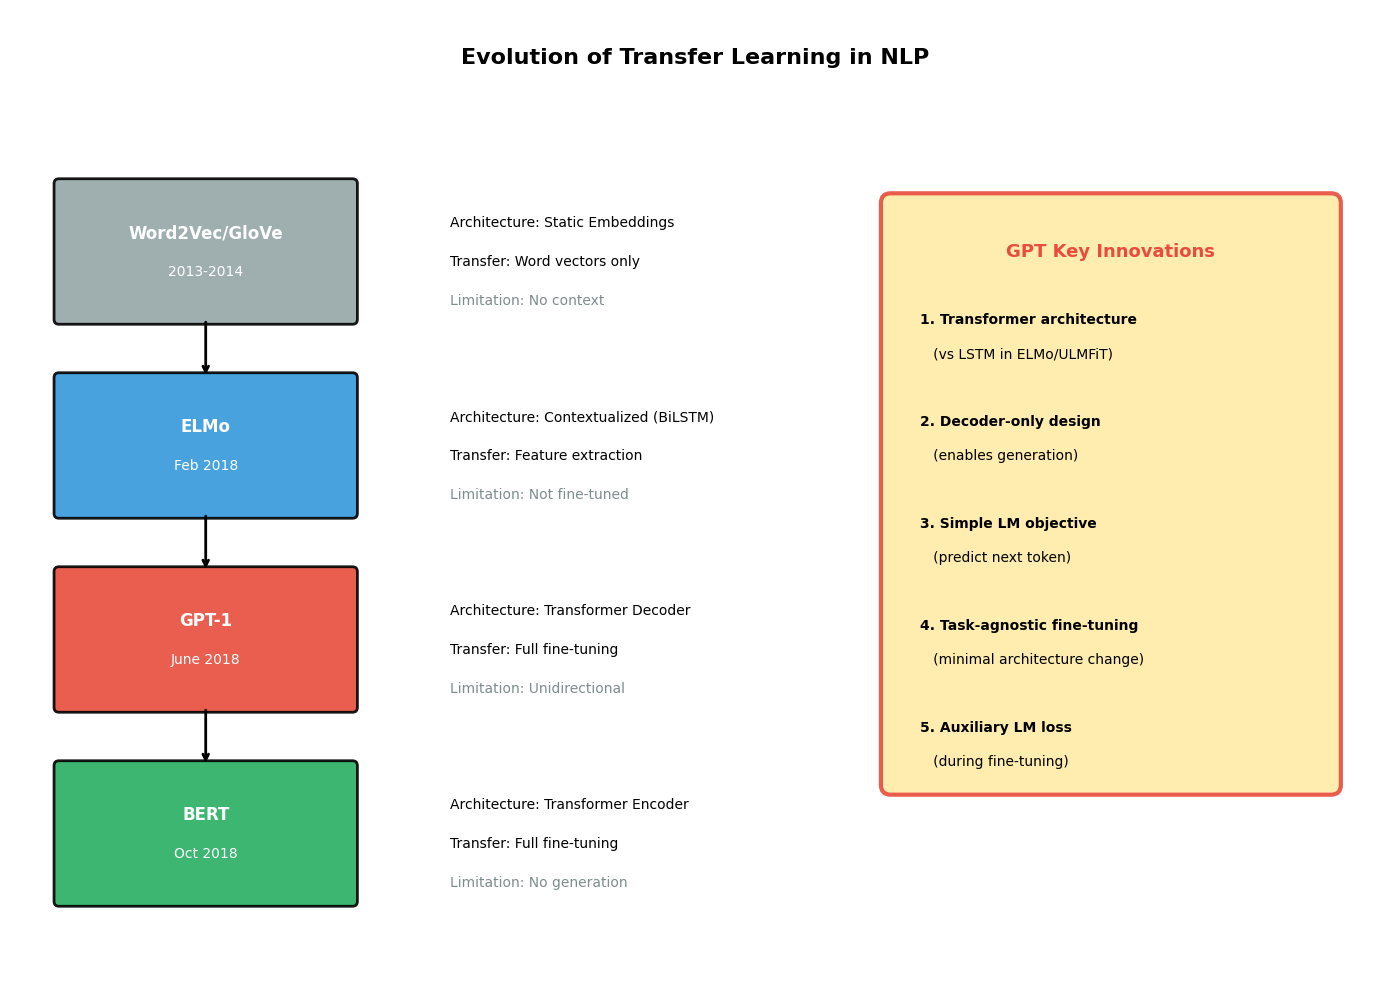

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(7, 9.5, 'Evolution of Transfer Learning in NLP', fontsize=16, fontweight='bold',
        ha='center', va='center')

# Define methods
methods = [
    {
        'name': 'Word2Vec/GloVe',
        'year': '2013-2014',
        'type': 'Static Embeddings',
        'transfer': 'Word vectors only',
        'limit': 'No context',
        'color': '#95a5a6',
        'y': 7.5
    },
    {
        'name': 'ELMo',
        'year': 'Feb 2018',
        'type': 'Contextualized (BiLSTM)',
        'transfer': 'Feature extraction',
        'limit': 'Not fine-tuned',
        'color': '#3498db',
        'y': 5.5
    },
    {
        'name': 'GPT-1',
        'year': 'June 2018',
        'type': 'Transformer Decoder',
        'transfer': 'Full fine-tuning',
        'limit': 'Unidirectional',
        'color': '#e74c3c',
        'y': 3.5
    },
    {
        'name': 'BERT',
        'year': 'Oct 2018',
        'type': 'Transformer Encoder',
        'transfer': 'Full fine-tuning',
        'limit': 'No generation',
        'color': '#27ae60',
        'y': 1.5
    }
]

for m in methods:
    # Box
    rect = FancyBboxPatch((0.5, m['y'] - 0.7), 3, 1.4,
                          boxstyle="round,pad=0.05",
                          facecolor=m['color'], edgecolor='black',
                          linewidth=2, alpha=0.9)
    ax.add_patch(rect)
    ax.text(2, m['y'] + 0.2, m['name'], ha='center', va='center',
            fontsize=12, fontweight='bold', color='white')
    ax.text(2, m['y'] - 0.2, m['year'], ha='center', va='center',
            fontsize=10, color='white')
    
    # Details
    ax.text(4.5, m['y'] + 0.3, f"Architecture: {m['type']}", fontsize=10, va='center')
    ax.text(4.5, m['y'] - 0.1, f"Transfer: {m['transfer']}", fontsize=10, va='center')
    ax.text(4.5, m['y'] - 0.5, f"Limitation: {m['limit']}", fontsize=10, va='center', color='#7f8c8d')

# Arrows showing progression
for i in range(len(methods) - 1):
    y1 = methods[i]['y'] - 0.7
    y2 = methods[i+1]['y'] + 0.7
    ax.annotate('', xy=(2, y2), xytext=(2, y1),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

# GPT innovations box
rect_gpt = FancyBboxPatch((9, 2), 4.5, 6,
                          boxstyle="round,pad=0.1",
                          facecolor='#ffeaa7', edgecolor='#e74c3c',
                          linewidth=3, alpha=0.9)
ax.add_patch(rect_gpt)

ax.text(11.25, 7.5, 'GPT Key Innovations', ha='center', va='center',
        fontsize=13, fontweight='bold', color='#e74c3c')

innovations = [
    '1. Transformer architecture',
    '   (vs LSTM in ELMo/ULMFiT)',
    '',
    '2. Decoder-only design',
    '   (enables generation)',
    '',
    '3. Simple LM objective',
    '   (predict next token)',
    '',
    '4. Task-agnostic fine-tuning',
    '   (minimal architecture change)',
    '',
    '5. Auxiliary LM loss',
    '   (during fine-tuning)'
]

for i, text in enumerate(innovations):
    y_pos = 6.8 - i * 0.35
    weight = 'bold' if text.startswith(('1', '2', '3', '4', '5')) else 'normal'
    ax.text(9.3, y_pos, text, fontsize=10, va='center', fontweight=weight)

plt.tight_layout()
plt.show()

---

## Summary: Part I

In this notebook, we covered:

### Historical Context
- GPT was published in June 2018, 4 months before BERT
- It was the first to combine Transformers with the pre-train/fine-tune paradigm

### The Core Problem
- Abundant unlabeled data, scarce labeled data
- Need for effective transfer learning in NLP

### The GPT Solution
- Stage 1: Unsupervised pre-training with language modeling
- Stage 2: Supervised fine-tuning with auxiliary LM loss

### Key Design Decisions
- Decoder-only Transformer (causal attention)
- Learned positional embeddings
- BPE tokenization
- Long-range pre-training data (BooksCorpus)

### Architecture Specifications
- 12 layers, 768 dimensions, 12 heads
- 3072 FFN inner dimension
- 512 max sequence length
- ~117M parameters

---

## What's Next

In **Part II**, we will:
- Implement the GPT architecture from scratch
- Build the causal self-attention mechanism
- Construct the full transformer decoder block

In **Part III**, we will:
- Implement the language modeling head
- Build the training loop with proper masking
- Understand the auxiliary loss for fine-tuning

In **Part IV**, we will:
- Explore task-specific input transformations
- Implement fine-tuning for different downstream tasks
- Analyze the learned representations

In **Part V**, we will:
- Complete implementation with generation capability
- Train on a dataset and evaluate
- Compare with BERT's approach

---

## References

1. Radford, A., Narasimhan, K., Salimans, T., & Sutskever, I. (2018). [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). OpenAI.

2. Vaswani, A., et al. (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762). NeurIPS.

3. Peters, M., et al. (2018). [Deep contextualized word representations (ELMo)](https://arxiv.org/abs/1802.05365). NAACL.

4. Howard, J., & Ruder, S. (2018). [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146). ACL.

5. Devlin, J., et al. (2018). [BERT: Pre-training of Deep Bidirectional Transformers](https://arxiv.org/abs/1810.04805). NAACL 2019.

Upvote if you learned something